# Линейная нейронная сеть. Правило обучения Уидроу-Хоффа

**Цель работы**: исследование свойств линейной нейронной сети и алгоритмов ее обучения, применение сети в задачах аппроксимации и фильтрации.

| <!-- --> | <!-- --> |
|:---------|:---------|
| Студент    | Почечура А.А.   |
| Группа   | М8О-406Б-20  |
| Вариант    | 18   |

In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import tqdm

###Задание 1

Для начала посчитаем значения функции с указанным шагом в варианте

In [2]:
def func(t):
  return torch.sin(torch.sin(t)*t*t - 2*t + 7)

h = 0.02
t_1 = torch.linspace(0, 4, int((4 - 0) / h + 1))
x_1 = [func(a) for a in t_1]

Напишем отдельную функцию, которая в список *x_train* будет класть группы значений в количестве *D* штук, а в списке *y_train* на соответствующем индексе будет содержаться значение, которое нейронная сеть должна предсказать по элементам из *x_train*. Например, на основании элементов, индексы которых начинаются с *i* и заканчиваются *i + D - 1*, будет предсказываться значение с индексом *i + D*.

In [3]:
def get_data(x, D):
  x_train = []
  y_train = []
  for i in range(0, len(x) - D):
    x_train.append(x[i:i+D])
    y_train.append(x[i+D])
  return x_train, y_train

Создадим класс *Perceptron*, с помощью которого мы будем тренировать нашу модель. Отличие от персептора из первой лабораторной: отсутствие функции активации (функция newline переводит элемент в себя же, поэтому нет смысла использовать данную функцию) и ошибка считается через корень от *MSE*.

In [4]:
class Perceptron(nn.Module):
  def __init__(self, inputs, outputs):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(inputs, outputs))
    self.bias = nn.Parameter(torch.randn(outputs))

  def forward(self, x):
    x = x @ self.weights + self.bias
    return x

  def fit(self, x_train, y_train, loss_fn, optimizer, goal, epochs):
    losses = []
    with tqdm(desc="epoch", total=epochs) as bar:
      for epoch in range(epochs):
        y_pred = self(x_train)
        loss = torch.sqrt(loss_fn(y_pred, y_train))
        loss.backward()
        l = loss.detach().numpy()
        if (goal >= l):
          break
        losses.append(l)
        optimizer.step()
        optimizer.zero_grad()
        bar.set_postfix({"current loss": l})
        bar.update()
    return losses

Зададим задержку *D* значением 5, подготовим данные для обучения модели и обучим её

In [5]:
D = 5
x_data_1, y_data_1 = get_data(x_1, D)
x_train_1 = torch.Tensor(x_data_1)
y_train_1 = torch.Tensor(y_data_1).view(-1,1)

In [6]:
perc_1 = Perceptron(D, 1)
loss_func = nn.MSELoss()
optimizer = torch.optim.SGD(perc_1.parameters(), lr=0.01)

In [9]:
l = perc_1.fit(x_train_1, y_train_1, loss_func, optimizer, 0, 50)

epoch: 100%|██████████| 50/50 [00:00<00:00, 579.90it/s, current loss=0.14265919]


Выведем полученные значения весов и смещения

In [10]:
for name, val in perc_1.named_parameters():
    print(name, ":\n", val.detach().numpy())

weights :
 [[-1.4885741 ]
 [ 1.2084615 ]
 [ 0.20590393]
 [ 0.6733446 ]
 [ 0.08656681]]
bias :
 [-0.03046433]


Отобразим график ошибок

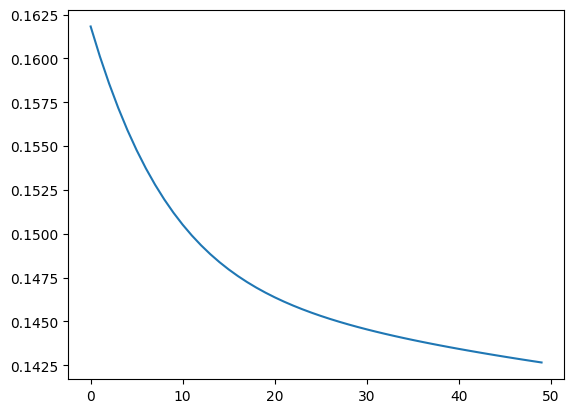

In [11]:
plt.plot(l)
plt.show()

Отобразим графики реальных значений и значений, которые были предсказаны нейросетью

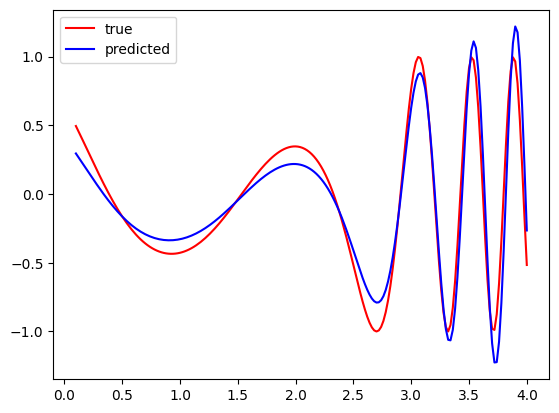

In [12]:
w = perc_1.weights.detach().numpy()
b = perc_1.bias.detach().numpy()

Y = x_train_1 @ w + b

plt.plot(t_1[D:], y_train_1, "red", label='true')
plt.plot(t_1[D:], Y, "blue", label='predicted')
plt.legend()
plt.show()

###Задание 2

Проделаем тот же алгоритм, что и в *Задании 1*, но со значением задержки *D = 3*

In [13]:
D = 3
x_data_2, y_data_2 = get_data(x_1, D)
x_train_2 = torch.Tensor(x_data_2)
y_train_2 = torch.Tensor(y_data_2).view(-1,1)

In [14]:
perc_2 = Perceptron(D, 1)
loss_func = nn.MSELoss()
optimizer = torch.optim.SGD(perc_2.parameters(), lr=0.1)

In [15]:
l = perc_2.fit(x_train_2, y_train_2, loss_func, optimizer, 1e-6, 600)

epoch: 100%|██████████| 600/600 [00:00<00:00, 645.09it/s, current loss=0.05143391]


Полученные значения весов и смещения

In [16]:
for name, val in perc_2.named_parameters():
    print(name, ":\n", val.detach().numpy())

weights :
 [[-0.2249435 ]
 [-0.56434065]
 [ 1.7029504 ]]
bias :
 [0.03462879]


График ошибок

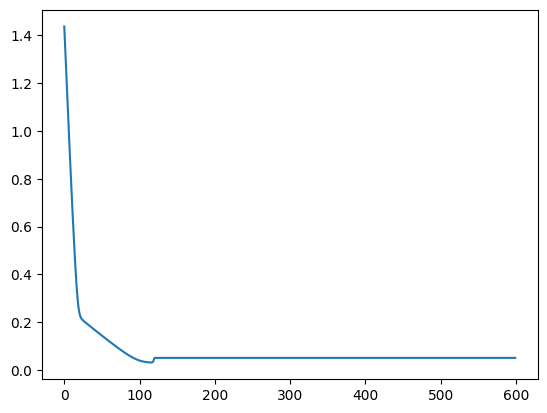

In [17]:
plt.plot(l)
plt.show()

Графики реальных и предсказанных значений

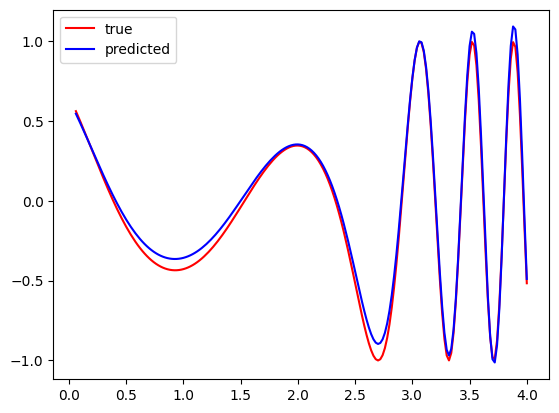

In [18]:
w = perc_2.weights.detach().numpy()
b = perc_2.bias.detach().numpy()

Y = x_train_2 @ w + b

plt.plot(t_1[D:], y_train_2, "red", label='true')
plt.plot(t_1[D:], Y, "blue", label='predicted')
plt.legend()
plt.show()

Теперь, на основе последних трёх значений функции на промежутке, попытаемся предсказать следующие 10 значений. Для этого сместим наш отрезок, оставив шаг тем же, но уменьшив количество значений до 13.

In [19]:
n = 10
t_2 = torch.linspace(4 - h * 2, 4 + h * 10, (n + 1) + 2)
x_2 = [func(a) for a in t_2]

Теперь список *x_train* будет состоять всего лишь из одного элемента, в который будет входить *D* значений - наша "база" для предсказания последующих элементов. *y_train* будет заполняться значениями функции, которые наша модель должна попыться предсказать

In [20]:
def get_data2(x, D):
  x_train = []
  x_train.append(x_2[:D])
  y_train = []
  for i in range(0, len(x) - D):
    y_train.append(x[i+D])
  return x_train, y_train

Подготавливаемя данные для предсказывания

In [25]:
x_data_2_2, y_data_2_2 = get_data2(x_2, D)

x_train_2_2 = torch.Tensor(x_data_2_2)
y_train_2_2 = torch.Tensor(y_data_2_2).view(-1,1)

В функции опишем алгоритм предсказания. На основе текущего списка *x_train* мы предсказываем следующее значение функции, используя веса *w* и смещение *b*, полученные нами в процессе обучения модели. После получения нового значения функции, обновляем *x_train*: выкидываем первое значение, а в конец добавляем наше только что предсказанное. Теперь мы готовы предсказать следующее значение. Повторяем это действие в цикле 10 раз.

In [26]:
def predict_y(x_train, D, n, w, b):
  y_pred = []
  x_cur = []
  for i in range(0, n):
    y_pred.append(x_train @ w + b)
    x_cur = x_train[0][1:D]
    x_cur.append(torch.tensor(y_pred[i][0][0]))
    x_train = [x_cur]
  return y_pred

Получаем список предсказанных значений

In [27]:
y_pred = predict_y(x_data_2_2, D, n, w, b)
y_pred = torch.Tensor(y_pred).view(-1,1)

Построим график ошибок, а также графики предсказанных значений и реальных значений функции

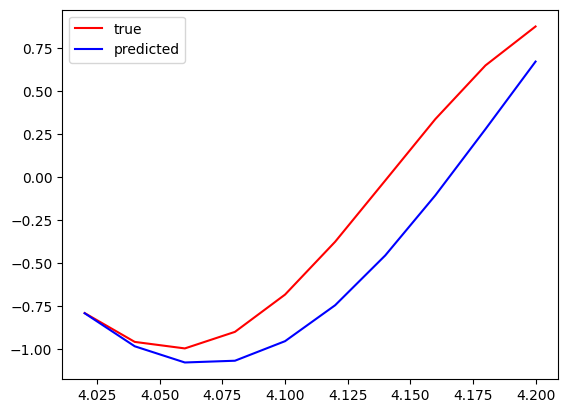

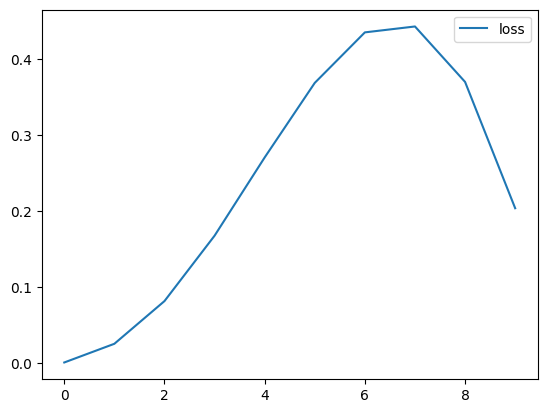

In [28]:
plt.plot(t_2[D:], y_train_2_2, "red", label='true')
plt.plot(t_2[D:], y_pred, "blue", label='predicted')
plt.legend()
plt.show()

l = [torch.sqrt(loss_func(a, b)) for a, b in zip(y_train_2_2, y_pred)]
plt.plot(l, label='loss')
plt.legend()
plt.show()

###Задание 3

Посчитаем значения новой функции с указанным шагом

In [92]:
def func2(t):
  return torch.cos(torch.cos(t)*t*t - t)

def func_ref(t):
  return ((torch.cos(torch.cos(t)*t*t - t + torch.pi)) / 5.0)

h = 0.01
t_3 = torch.linspace(1, 4.5, int((4.5 - 1) / h + 1))
x_3 = [func2(a) for a in t_3]

В данном задании мы будем пресказывать значения и сверять их со значениями другой функции. Поэтому элементам списка *x_train* будет соответствовать значение значение функции *func_ref*, записанное в список *y_train*. В списке pred будем записывать значение функции *func2* (по аналогии с *заданием 1*).

In [93]:
def get_data3(x, D):
  x_train = []
  y_train = []
  pred = []
  for i in range(0, len(x) - D):
    x_train.append(x[i:i+D])
    y_train.append(func_ref(t_3[i+D]))
    pred.append(x[i+D])
  return x_train, y_train, pred

Подготовим наши данные для обучения модели и обучим для значения задержки *D = 3*

In [103]:
D = 4
x_data_3, y_data_3, pred_3 = get_data3(x_3, D)
x_train_3 = torch.Tensor(x_data_3)
y_train_3 = torch.Tensor(y_data_3).view(-1,1)

In [104]:
perc_3 = Perceptron(D, 1)
loss_func = nn.MSELoss()
optimizer = torch.optim.SGD(perc_3.parameters(), lr=0.01)

In [105]:
l = perc_3.fit(x_train_3, y_train_3, loss_func, optimizer, 0, 100)

epoch: 100%|██████████| 100/100 [00:00<00:00, 578.51it/s, current loss=0.04941665]


Выведем полученные веса и смещение

In [106]:
for name, val in perc_3.named_parameters():
    print(name, ":\n", val.detach().numpy())

weights :
 [[-0.05333987]
 [-0.16548824]
 [-0.30305505]
 [ 0.32590777]]
bias :
 [0.00050373]


Изобразим значения ошибок на графике

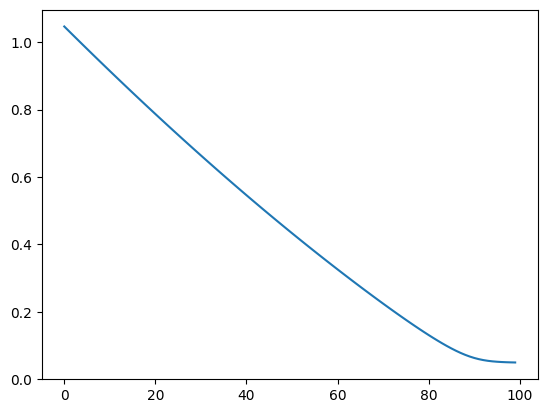

In [107]:
plt.plot(l)
plt.show()

Изобразим три графика: предсказанные значения (*predicted*), значения функции *func_ref* (*noise*), по которым считалась ошибка при обучении модели, и значения функции *func2* (*true*)

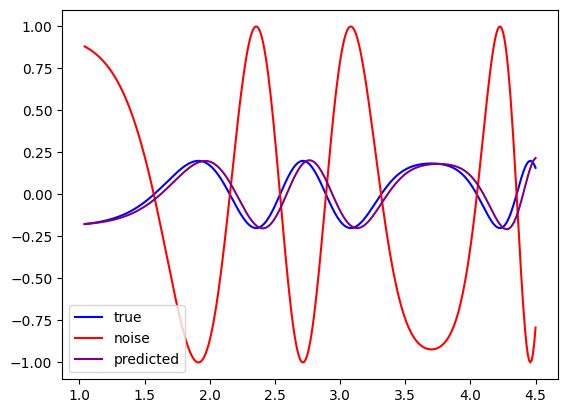

In [112]:
w = perc_3.weights.detach().numpy()
b = perc_3.bias.detach().numpy()

Y = x_train_3 @ w + b

plt.plot(t_3[D:], y_train_3, "blue", label='true')
plt.plot(t_3[D:], pred_3, "red", label='noise')
plt.plot(t_3[D:], Y, "purple", label='predicted')
plt.legend()
plt.show()

**Вывод:** в ходе выполнения данной лабораторной работы я научился использовать линейную нейронную сеть с задержками для аппроксимации функции (предсказывания значний), использовать её как адаптивный фильтр для подавления помех. Нейронная сеть очень хорошо справилась со своей задачей, но всё таки бывают случаи, когда погрешность в вычислениях становится значительной. Это можно исправить, увеличив количество эпох обучения, или уменьшив/увеличив скорость обучения модели.